In [38]:
import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from ipywidgets import interactive, fixed, widgets
from IPython.display import display
from scipy import optimize
%ls img

img_path = './img/Img1.jpg'

ImagenProcesada.jpg  Img12.jpg  Img1.jpg  Img3.jpg  Img6.jpg
Img11.jpg            Img15.jpg  Img2.jpg  Img5.jpg  Prueba.jpg


56.060885416666665


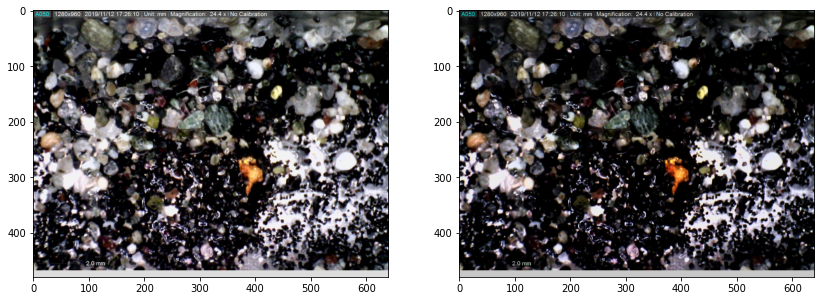

In [39]:
img = cv2.imread(img_path)
img = cv2.resize(img, (640, 480))
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
img_light = img[:, :, 1]
img_light = img_light[img_light > 50]

def average_light(gamma):
    return np.mean(255 * (img_light / 255) ** gamma) - 100

gamma = optimize.newton(average_light, 1, tol=0.01)
img = (255 * (img / 255) ** gamma).astype(np.uint8)
print(np.mean(cv2.cvtColor(img, cv2.COLOR_BGR2HLS)[:, :, 1]))
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [20]:
img = cv2.imread(img_path)
#img = cv2.resize(img, (640, 480))
#img = cv2.blur(img, ksize=(10, 10))
img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

hsv_scale = np.zeros((180, 256, 3), dtype=np.uint8)
hsv_scale[:, :, 0] = np.linspace(0, 179, 180).reshape(-1, 1)
hsv_scale[:, :, 2] = 255

def transform_img_hsv(img, low_h, high_h, low_s, low_v):
    trigger_h = low_h
    thresh_h = high_h
    trigger_s = low_s
    trigger_v = low_v
    hsv_scale[:, :, 1] = np.linspace(trigger_s, 255, 256).reshape(1, -1)
    color_rng = (np.array([trigger_h, trigger_s, trigger_v]), np.array([thresh_h, 255, 255]))
    mask = cv2.inRange(img, *color_rng)
    img = cv2.bitwise_and(img, img, mask=mask)
    img[:, :, 2][img[:, :, 2] > 0] = 255
    #img[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    
    img = cv2.cvtColor(
        cv2.erode(
            cv2.cvtColor(img, cv2.COLOR_HSV2BGR),
            np.ones((5, 5))
        ),
        cv2.COLOR_BGR2HSV
    )

In [21]:
img = cv2.imread(img_path)
#img = cv2.resize(img, (640, 480))
#img = cv2.blur(img, ksize=(10, 10))
img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

hsv_scale = np.zeros((180, 256, 3), dtype=np.uint8)
hsv_scale[:, :, 0] = np.linspace(0, 179, 180).reshape(-1, 1)
hsv_scale[:, :, 2] = 255

def transform_img_hsv(img, low_h, high_h, low_s, low_v):
    trigger_h = low_h
    thresh_h = high_h
    trigger_s = low_s
    trigger_v = low_v
    hsv_scale[:, :, 1] = np.linspace(trigger_s, 255, 256).reshape(1, -1)
    color_rng = (np.array([trigger_h, trigger_s, trigger_v]), np.array([thresh_h, 255, 255]))
    mask = cv2.inRange(img, *color_rng)
    img = cv2.bitwise_and(img, img, mask=mask)
    img[:, :, 2][img[:, :, 2] > 0] = 255
    #img[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
    
#    img = cv2.cvtColor(
#        cv2.erode(
#            cv2.cvtColor(img, cv2.COLOR_HSV2BGR),
#            np.ones((5, 5))
#        ),
#        cv2.COLOR_BGR2HSV
#    )
    
    hue = img[:, :, 0][img[:, :, 2] == 255]
    sat = img[:, :, 1][img[:, :, 2] == 255]
    low_line = np.arange(hsv_scale.shape[1]), trigger_h * np.ones(hsv_scale.shape[1])
    high_line = np.arange(hsv_scale.shape[1]), thresh_h * np.ones(hsv_scale.shape[1])
    plt.figure()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_HSV2RGB))
    plt.figure()
    plt.imshow(cv2.cvtColor(hsv_scale, cv2.COLOR_HSV2RGB))
    plt.plot(*low_line, 'black')
    plt.plot(*high_line, 'black')
    plt.plot(sat, hue, 'o', markersize=8)


display(interactive(
    transform_img_hsv,
    img=fixed(img),
    low_h=widgets.IntSlider(min=0, max=179, value=12),
    high_h=widgets.IntSlider(min=0, max=179, value=20),
    low_s=widgets.IntSlider(min=0, max=255, value=170),
    low_v=widgets.IntSlider(min=0, max=255, value=130),
))

interactive(children=(IntSlider(value=12, description='low_h', max=179), IntSlider(value=20, description='high…

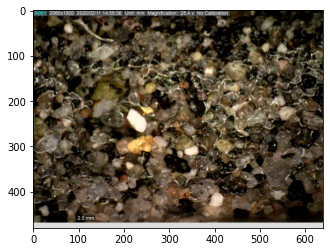

In [43]:
img_path = './img/Img3.jpg'
img_org = cv2.imread(img_path)
img_org = cv2.resize(img_org, (640, 480))
img = cv2.blur(img, ksize=(5, 5))
GOLD_AREA_TRESHOLD = 70

hls_scale = np.zeros((180, 256, 3), dtype=np.uint8)
hls_scale[:, :, 0] = np.linspace(0, 179, 180).reshape(-1, 1)
hls_scale[:, :, 1] = 127


def average_light(gamma, img_light):
    return np.mean(255 * (img_light / 255) ** gamma) - 80

def standarize_brightness(img):
    img_light = img[:, :, 1]
    img_light = img_light[img_light > 50]
    return optimize.newton(average_light, 1, args=(img_light,), tol=0.01)

def evaluate_gold_for_area(img, area_treshold, org_img):
    has_gold = 0
    img_edged = cv2.Canny(img, 30, 200)
    contours, hierarchy = cv2.findContours(img_edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    img_with_contours = img.copy()
    img_with_contours = cv2.cvtColor(img_with_contours, cv2.COLOR_HLS2RGB)
    cv2.drawContours(img_with_contours, contours, -1, (0, 255, 0), 2)
    cv2.drawContours(org_img, contours, -1, (0, 255, 0), 2)
    #print("Contours in the image -> ", len(contours))    
    plt.figure()
    plt.imshow(img_with_contours)
    
    for contour in contours:
        area = cv2.contourArea(contour)
        print("Area ->", area)
        if area > GOLD_AREA_TRESHOLD:
            has_gold = 1
    return has_gold

def transform_img_hls(img, low_h, high_h, low_s, low_l, high_l, gamma):
    hls_scale[:, :, 2] = np.linspace(low_s, 255, 256).reshape(1, -1)
    img = img.copy()
    img = (255 * (img / 255) ** gamma).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    color_rng = (np.array([low_h, low_l, low_s]), np.array([high_h, high_l, 255]))
    mask = cv2.inRange(img, *color_rng)
    img = cv2.bitwise_and(img, img, mask=mask)
    
    img = cv2.cvtColor(img, cv2.COLOR_HLS2BGR)
    img = cv2.erode(img, np.ones((1, 1)))
    img = cv2.dilate(img, np.ones((5, 5)))
    img = cv2.erode(img, np.ones((8, 8)))
    img = cv2.dilate(img, np.ones((8, 8)))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    
    #img_bin = np.zeros((img.shape[0], img.shape[1]), np.uint8)
    #img_bin[img[:, :, 2] > 0] = 255
    #contours, hierarchy = cv2.findContours(img_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #print(len(contours))
    #mask = np.zeros(img_bin.shape, np.uint8)
    #for cnt in contours:
    #    sub_mask = cv2.drawContours(mask, [cnt], 0, 255, -1)
    #    mean_hue = np.mean(img[:, :, 0][sub_mask > 0])
    #    print(mean_hue)
    #    if 15 < mean_hue < 17:
    #        mask = cv2.bitwise_or(mask, sub_mask)
    #img = cv2.bitwise_and(img, img, mask=mask)
    
    # Determine if the image have gold for area analysis
    has_gold = evaluate_gold_for_area(img, GOLD_AREA_TRESHOLD, img_org)
    if has_gold == 1:
        print("Exists gold in this sample")
    else:
        print("Don't exists gold in this sample")
    
    hue = img[:, :, 0][img[:, :, 1] != 0]
    sat = img[:, :, 2][img[:, :, 1] != 0]
    low_line = np.arange(hls_scale.shape[1]), low_h * np.ones(hls_scale.shape[1])
    high_line = np.arange(hls_scale.shape[1]), high_h * np.ones(hls_scale.shape[1])
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB))
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_HLS2RGB))
    plt.figure()
    plt.imshow(cv2.cvtColor(hls_scale, cv2.COLOR_HLS2RGB))
    plt.plot(*low_line, 'black', linewidth=1.0)
    plt.plot(*high_line, 'black', linewidth=1.0)
    plt.plot(sat, hue, 'o', markersize=5)

display(interactive(
    transform_img_hls,
    img=fixed(img_org),
    low_h=widgets.IntSlider(min=0, max=179, value=13),
    high_h=widgets.IntSlider(min=0, max=179, value=19),
    low_s=widgets.IntSlider(min=0, max=255, value=140),
    low_l=widgets.IntSlider(min=0, max=255, value=100),
    high_l=widgets.IntSlider(min=0, max=255, value=190),
    gamma=widgets.FloatLogSlider(min=-4, max=1, value=2.0, step=0.05),
))

interactive(children=(IntSlider(value=13, description='low_h', max=179), IntSlider(value=19, description='high…

In [330]:
arr = np.array([[1, 1], [2, 2]])

In [73]:
arr[arr == 2] = 3

In [77]:
arr[arr == 3]

array([3, 3])